In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import os
from PIL import Image
import random
import csv

/home/samantha/miniconda3/envs/ml/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path = "/home/samantha/Desktop/mihir mess/datasets/COVID Classification/"
infectedImg_path = path + 'COVID'
healthyImg_path = path + 'non-COVID'

In [3]:
#Creating a CSV file since this dataset doesn't have one
fields = ['ImgName', 'Label']
filename = 'dataset.csv'
filepath = os.path.join(path, filename)
data = []
for i in os.listdir(infectedImg_path):
    if i[0] != '.':
        data.append([i, 1])

for i in os.listdir(healthyImg_path):
    if i[0] != '.':
        data.append([i, 0])

random.shuffle(data)

with open(filepath, 'w') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(fields)
    csvwriter.writerows(data)

In [4]:
len(data)

3227

In [5]:
#Loading the dataset
df = pd.read_csv(filepath)

#Splitting it into test and train dataset
df['split'] = np.random.randn(df.shape[0], 1)
msk = np.random.rand(len(df)) <= 0.8

train_df = df[msk]
test_df = df[~msk]

In [6]:
train_df.head()

,ImgName,Label,split
0,Covid (126).png,1,0.577519
1,Covid (244).png,1,-0.088331
3,Non-Covid (510).png,0,0.731508
4,63%4.jpg,0,-0.648744
6,35%0.jpg,0,-2.317535


In [7]:
#Creating the container object for images and labels

class COVIDClassificationDataset(Dataset):
    def __init__(self, dataFrame, root_dir, transform = None):
        self.dataFrame = dataFrame
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.dataFrame)
    
    def __getitem__(self, idx):
        label = self.dataFrame.iloc[idx, 1]
        if label == 0:
            newDir = os.path.join(self.root_dir, 'non-COVID')
        elif label == 1:
            newDir = os.path.join(self.root_dir, 'COVID')
        img_name = os.path.join(newDir, self.dataFrame.iloc[idx, 0])
        image = Image.open(img_name).convert("RGB")
        
        if self.transform:
            image = self.transform(image)

        return (image, label)

In [8]:
img_transform = transforms.Compose([
    transforms.Resize(250),
    transforms.CenterCrop(227),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),


])

In [9]:
covid_train = COVIDClassificationDataset(dataFrame=train_df, root_dir= path, transform=img_transform)
covid_test = COVIDClassificationDataset(dataFrame=test_df, root_dir=path, transform=img_transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


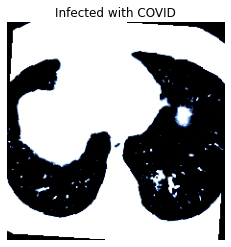

In [10]:
#Visualizing the image
import matplotlib.pyplot as plt

temp_img, temp_lab = covid_train[0]
plt.imshow(temp_img.numpy().transpose((1, 2, 0)))
if temp_lab:
    plt.title("Infected with COVID")
else:
    plt.title("Healthy")
plt.axis('off')
plt.show()

In [11]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [12]:
device

device(type='cuda')

In [13]:
#Dataloader
train_loader = DataLoader(dataset=covid_train, batch_size=16, shuffle=True)
test_loader = DataLoader(dataset=covid_test, batch_size=16, shuffle=False)

In [14]:
#Transfer learning
model = torchvision.models.densenet121(pretrained=False)

/home/samantha/miniconda3/envs/ml/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/samantha/miniconda3/envs/ml/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [15]:
num_features = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Linear(num_features, 500),
    nn.Linear(500, 2)
)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, amsgrad=True)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[500,1000,1500], gamma=0.5)

In [26]:
num_ep = 100
n_steps = len(train_loader)
for ep in range(num_ep):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        #Forward Pass
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)

        #Backward Pass
        loss.backward()
        optimizer.step()
    
    print(f'Epoch: [{ep + 1} / {num_ep}], Loss: {loss.item():.4f}')

Epoch: [1 / 100], Loss: 0.7306
Epoch: [2 / 100], Loss: 0.6774
Epoch: [3 / 100], Loss: 0.6284
Epoch: [4 / 100], Loss: 0.7090
Epoch: [5 / 100], Loss: 0.5219
Epoch: [6 / 100], Loss: 0.4055
Epoch: [7 / 100], Loss: 0.3087
Epoch: [8 / 100], Loss: 0.5201
Epoch: [9 / 100], Loss: 0.6222
Epoch: [10 / 100], Loss: 0.5713
Epoch: [11 / 100], Loss: 0.4010
Epoch: [12 / 100], Loss: 0.3292
Epoch: [13 / 100], Loss: 0.3089
Epoch: [14 / 100], Loss: 0.6117
Epoch: [15 / 100], Loss: 0.3997
Epoch: [16 / 100], Loss: 0.2252
Epoch: [17 / 100], Loss: 0.4244
Epoch: [18 / 100], Loss: 0.5669
Epoch: [19 / 100], Loss: 0.3900
Epoch: [20 / 100], Loss: 0.3762
Epoch: [21 / 100], Loss: 0.2297
Epoch: [22 / 100], Loss: 0.2478
Epoch: [23 / 100], Loss: 0.4700
Epoch: [24 / 100], Loss: 0.5997
Epoch: [25 / 100], Loss: 0.5262
Epoch: [26 / 100], Loss: 0.2395
Epoch: [27 / 100], Loss: 0.4495
Epoch: [28 / 100], Loss: 0.2182
Epoch: [29 / 100], Loss: 0.2146
Epoch: [30 / 100], Loss: 0.6117
Epoch: [31 / 100], Loss: 0.1439
Epoch: [32 / 100]

In [28]:
model.eval()
correct = 0
total_pred = 0
for x, fn in test_loader:
    with torch.no_grad():
        x = x.to(device)
        output = model(x)
        pred = torch.argmax(output, dim = 1)
        for i in range(len(pred)):
            total_pred += 1
            if pred[i] == fn[i]:
                correct += 1


#Accuracy of the model
acc = 100 * correct / total_pred
print(f'Accuracy of the Model: {acc:.2f}')

Accuracy of the Model: 91.32
